In [10]:
import pickle
import pickletools
import utils
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import t

# Single Data

### Note that this needs the experiment to be finished
### The graph only considers UEs that involves in handover. Some UEs lost connections without handover will not be here.

In [11]:
def separate_waiting_time(result_waiting_time, result_success_or_failure):
    result_waiting_time_success = []
    result_waiting_time_failure = []
    for id in result_waiting_time:
        if result_success_or_failure[id]:
            result_waiting_time_success.append(result_waiting_time[id])
        else:
            result_waiting_time_failure.append(result_waiting_time[id])
    return result_waiting_time_success, result_waiting_time_failure

def stat(values, confidence):
    v = np.array(values)
    m = v.mean()
    s = v.std()
    dof = len(v) - 1
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    c = (m-s*t_crit/np.sqrt(len(v)), m+s*t_crit/np.sqrt(len(v)))
    print(f"  # Confidence Interval: {round(m,2)}±{round(s*t_crit/np.sqrt(len(v)),2)}")
    
def gives_result(path,sat_id, draw=False):
    with open(path, 'rb') as inp:
        data = pickle.load(inp)
    res = {}
    for ue_id in data.UE_time_stamp:
        UE_time = data.UE_time_stamp[ue_id]
        for each in UE_time:
            if each['from'] == sat_id:
                res[ue_id] = each
    res_waiting_time = {}
    res_success_or_failure = {}

    for id in res:
        r = res[id]
        res_waiting_time[id] = (r['timestamp'][-1] - r['timestamp'][0])
        res_success_or_failure[id] = r['isSuccess']
        
    waiting_time_success, waiting_time_failure = separate_waiting_time(res_waiting_time, res_success_or_failure)

    print(f"Success Rate: {len(waiting_time_success)}/{len(waiting_time_failure) + len(waiting_time_success)} = {100*len(waiting_time_success)/(len(waiting_time_failure) + len(waiting_time_success))}%")
    if len(waiting_time_success) != 0:
        print(f"Success UE waiting time: ")
        stat(waiting_time_success,0.95)
    if len(waiting_time_failure) != 0:
        print(f"Failure UE waiting time: ")
        stat(waiting_time_failure,0.95)

    total = data.cumulative_total_messages[sat_id][-1]
    UE_message = data.cumulative_message_from_UE_measurement[sat_id][-1]
    UE_retransmit = data.cumulative_message_from_UE_retransmit[sat_id][-1]
    group_UE_message = data.cumulative_message_from_UE_Group[sat_id][-1]
    group_UE_message_retransmit = data.cumulative_message_from_UE_Group_retransmit[1][-1]
    
    satellite = data.cumulative_message_from_satellite[sat_id][-1]
    
    dropped_from_group = data.cumulative_message_from_dropped_from_group[sat_id][-1]
    dropped_from_non_group = data.cumulative_message_from_dropped_from_non_group[sat_id][-1]

    UE = UE_message + UE_retransmit + group_UE_message + group_UE_message_retransmit
    dropped = dropped_from_group + dropped_from_non_group

    print(f"Total message received: {total}")
    print(f" messages received from satellite (% to total messages): {(satellite)} ({round(100*(satellite)/total, 2)}%)")
    print(f" requests received from UE (% to total messages): {(UE)} ({round(100*(UE)/total, 2)}%)")
    print(f"   # dropped messages (% to UE messages) {dropped} ({round(100 * dropped / (total), 2)}%)")
    print(f"   # group messages (% to UE) {round((group_UE_message + group_UE_message_retransmit)/UE * 100, 2)}%")
    
    if draw:
        fig, axes = plt.subplots(1, 3, figsize=(36*0.8, 12*0.8))
        size = 0.3
        
        UE_positions = data.UE_positions
        pop_keys = []
        for id in UE_positions:
            if id not in res:
                pop_keys.append(id)
        for key in pop_keys:
            UE_positions.pop(key)
            
        # Combined Graph
        pos_x = np.array([UE_positions[id][0] for id in UE_positions])
        pos_y = np.array([UE_positions[id][1] for id in UE_positions])
        res_success_or_failure_array = np.array([res_success_or_failure[id] for id in UE_positions])
        colors = np.where(res_success_or_failure_array, 'g', 'red')
        axes[0].scatter(x=pos_x, y=pos_y, c=colors, alpha=1, s = size)
        axes[0].set_facecolor("black")
        
        # Success
        success_UE_positions = {}
        for id in UE_positions:
            if res_success_or_failure[id]:
                success_UE_positions[id] = UE_positions[id]
        if len(success_UE_positions) != 0:
            pos_x = np.array([success_UE_positions[id][0] for id in success_UE_positions])
            pos_y = np.array([success_UE_positions[id][1] for id in success_UE_positions])
            axes[1].scatter(x=pos_x, y=pos_y, c='g', alpha=1, s = size)
            axes[1].set_facecolor("black")
        
        # Failure
        failure_UE_positions = {}
        for id in UE_positions:
            if not res_success_or_failure[id]:
                failure_UE_positions[id] = UE_positions[id]
        if len(failure_UE_positions) != 0:
            pos_x = np.array([failure_UE_positions[id][0] for id in failure_UE_positions])
            pos_y = np.array([failure_UE_positions[id][1] for id in failure_UE_positions])
            axes[2].scatter(x=pos_x, y=pos_y, c='r', alpha=1, s = size)
            axes[2].set_facecolor("black")

In [12]:
gives_result('./10000/graph_datadata_object.pkl', 1, False)

Success Rate: 10000/10000 = 100.0%
Success UE waiting time: 
  # Confidence Interval: 15.88±0.4
Total message received: 16554
 messages received from satellite (% to total messages): 1747 (10.55%)
 requests received from UE (% to total messages): 4807 (29.04%)
   # dropped messages (% to UE messages) 0 (0.0%)
   # group messages (% to UE) 95.49%


In [13]:
gives_result('./20000/graph_datadata_object.pkl', 1, False)

Success Rate: 20000/20000 = 100.0%
Success UE waiting time: 
  # Confidence Interval: 19.51±0.33
Total message received: 26764
 messages received from satellite (% to total messages): 1760 (6.58%)
 requests received from UE (% to total messages): 5004 (18.7%)
   # dropped messages (% to UE messages) 0 (0.0%)
   # group messages (% to UE) 97.24%


In [14]:
gives_result('./30000/graph_datadata_object.pkl', 1, False)

Success Rate: 30000/30000 = 100.0%
Success UE waiting time: 
  # Confidence Interval: 23.11±0.29
Total message received: 37070
 messages received from satellite (% to total messages): 1909 (5.15%)
 requests received from UE (% to total messages): 5161 (13.92%)
   # dropped messages (% to UE messages) 0 (0.0%)
   # group messages (% to UE) 94.52%


In [15]:
gives_result('./40000/graph_datadata_object.pkl', 1, False)

Success Rate: 40000/40000 = 100.0%
Success UE waiting time: 
  # Confidence Interval: 25.44±0.27
Total message received: 47572
 messages received from satellite (% to total messages): 2095 (4.4%)
 requests received from UE (% to total messages): 5477 (11.51%)
   # dropped messages (% to UE messages) 0 (0.0%)
   # group messages (% to UE) 92.62%


In [16]:
gives_result('./50000/graph_datadata_object.pkl', 1, False)

Success Rate: 50000/50000 = 100.0%
Success UE waiting time: 
  # Confidence Interval: 61.09±0.42
Total message received: 65818
 messages received from satellite (% to total messages): 4383 (6.66%)
 requests received from UE (% to total messages): 11435 (17.37%)
   # dropped messages (% to UE messages) 0 (0.0%)
   # group messages (% to UE) 92.82%


In [17]:
gives_result('./60000/graph_datadata_object.pkl', 1, False)

Success Rate: 55564/60000 = 92.60666666666667%
Success UE waiting time: 
  # Confidence Interval: 343.72±2.11
Failure UE waiting time: 
  # Confidence Interval: 444.71±4.54
Total message received: 124675
 messages received from satellite (% to total messages): 19240 (15.43%)
 requests received from UE (% to total messages): 49871 (40.0%)
   # dropped messages (% to UE messages) 1947 (1.56%)
   # group messages (% to UE) 93.12%


# Batch - Non Group

In [18]:
with open('./10000/graph_datadata_object.pkl', 'rb') as inp:
    data10000 = pickle.load(inp)
with open('./20000/graph_datadata_object.pkl', 'rb') as inp:
    data20000 = pickle.load(inp)
with open('./30000/graph_datadata_object.pkl', 'rb') as inp:
    data30000 = pickle.load(inp)
with open('./40000/graph_datadata_object.pkl', 'rb') as inp:
    data40000 = pickle.load(inp)
with open('./50000/graph_datadata_object.pkl', 'rb') as inp:
    data50000 = pickle.load(inp)
with open('./60000/graph_datadata_object.pkl', 'rb') as inp:
    data60000 = pickle.load(inp)
with open('./70000/graph_datadata_object.pkl', 'rb') as inp:
    data70000 = pickle.load(inp)
x = data10000.x

label = ['10000', '20000', '30000', '40000', '50000', '60000', '70000']
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']#, 'deeppink', 'gold', 'orange', 'midnightblue', 'brown', 'grey']
#data = [data10000, data15000, data20000, data25000, data30000, data35000, data40000, data45000, data50000, data55000, data60000, data65000, data70000]
data = [data10000, data20000, data30000, data40000, data50000, data60000, data70000]

total_rate = []
drop_rate = []


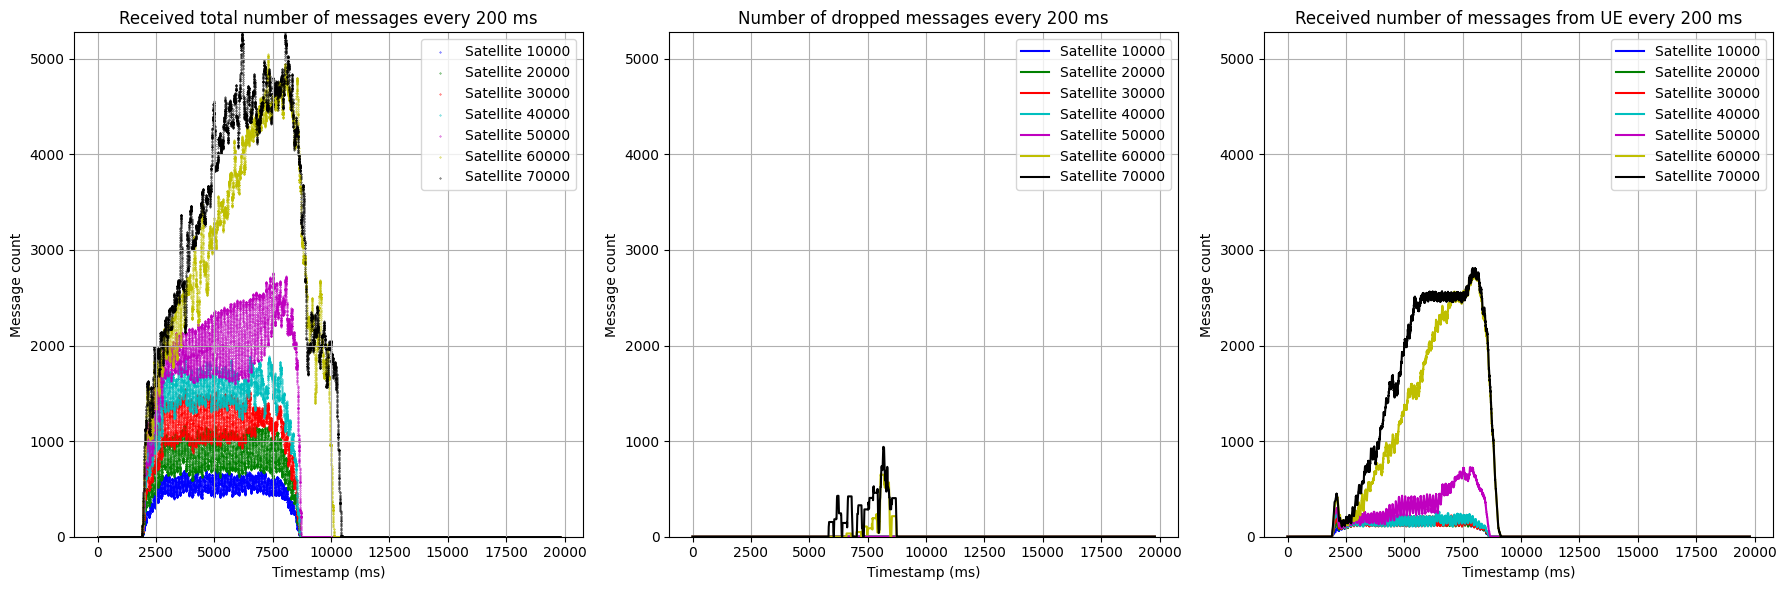

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sat_id = 1
interval = 200

max_y = 0
for i in range(len(data)):
    l = np.array(data[i].cumulative_total_messages[sat_id])
    l_diff = l[interval:] - l[:-interval]
    max_y = max(max_y, np.max(l_diff))

for i in range(len(data)):
    l = np.array(data[i].cumulative_total_messages[sat_id])
    l_diff = l[interval:] - l[:-interval]
    total_rate.append(l_diff)
    axes[0].scatter(range(len(l_diff)), l_diff, label=f'Satellite {label[i]}', color=color[i], s = 0.1)

axes[0].set_ylim(0, max_y)
axes[0].set_xlabel('Timestamp (ms)')
axes[0].set_ylabel('Message count')
axes[0].legend()
axes[0].set_title(f'Received total number of messages every {interval} ms')
axes[0].grid(True)

for i in range(len(data)):
    l = (np.array(data[i].cumulative_message_from_dropped_from_group[sat_id])
        +np.array(data[i].cumulative_message_from_dropped_from_non_group[sat_id]))
    l_diff = l[interval:] - l[:-interval]
    drop_rate.append(l_diff)
    axes[1].plot(l_diff, label=f'Satellite {label[i]}', color=color[i])

axes[1].set_ylim(0, max_y)
axes[1].set_xlabel('Timestamp (ms)')
axes[1].set_ylabel('Message count')
axes[1].legend()
axes[1].set_title(f'Number of dropped messages every {interval} ms')
axes[1].grid(True)

for i in range(len(data)):
    l = (np.array(data[i].cumulative_message_from_UE_measurement[sat_id])
                +np.array(data[i].cumulative_message_from_UE_retransmit[sat_id])
                +np.array(data[i].cumulative_message_from_UE_Group[sat_id])
                +np.array(data[i].cumulative_message_from_UE_Group_retransmit[sat_id]))
    l_diff = l[interval:] - l[:-interval]
    axes[2].plot(l_diff, label=f'Satellite {label[i]}', color=color[i])

axes[2].set_ylim(0, max_y)
axes[2].set_xlabel('Timestamp (ms)')
axes[2].set_ylabel('Message count')
axes[2].legend()
axes[2].set_title(f'Received number of messages from UE every {interval} ms')
axes[2].grid(True)

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

In [20]:
with open('total_rate.pickle', 'wb') as handle:
    pickle.dump(np.array(total_rate), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('drop_rate.pickle', 'wb') as handle:
    pickle.dump(np.array(drop_rate), handle, protocol=pickle.HIGHEST_PROTOCOL)

# Batch - Group

# Batch Graph

In [ ]:
with open('./10000/graph_datadata_object.pkl', 'rb') as inp:
    data10000 = pickle.load(inp)
with open('./15000/graph_datadata_object.pkl', 'rb') as inp:
    data15000 = pickle.load(inp)
with open('./20000/graph_datadata_object.pkl', 'rb') as inp:
    data20000 = pickle.load(inp)
with open('./25000/graph_datadata_object.pkl', 'rb') as inp:
    data25000 = pickle.load(inp)
with open('./30000/graph_datadata_object.pkl', 'rb') as inp:
    data30000 = pickle.load(inp)
with open('./35000/graph_datadata_object.pkl', 'rb') as inp:
    data35000 = pickle.load(inp)
with open('./40000/graph_datadata_object.pkl', 'rb') as inp:
    data40000 = pickle.load(inp)
with open('./45000/graph_datadata_object.pkl', 'rb') as inp:
    data45000 = pickle.load(inp)
with open('./50000/graph_datadata_object.pkl', 'rb') as inp:
    data50000 = pickle.load(inp)
with open('./55000/graph_datadata_object.pkl', 'rb') as inp:
    data55000 = pickle.load(inp)
with open('./60000/graph_datadata_object.pkl', 'rb') as inp:
    data60000 = pickle.load(inp)
with open('./65000/graph_datadata_object.pkl', 'rb') as inp:
    data65000 = pickle.load(inp)
with open('./70000/graph_datadata_object.pkl', 'rb') as inp:
    data70000 = pickle.load(inp)
x = data10000.x
label = ['10000', '15000', '20000', '25000', '30000', '35000', '40000', '45000', '50000', '55000', '60000', '65000', '70000']
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'deeppink', 'gold', 'orange', 'midnightblue', 'brown', 'grey']
data = [data10000, data15000, data20000, data25000, data30000, data35000, data40000, data45000, data50000, data55000, data60000, data65000, data70000]




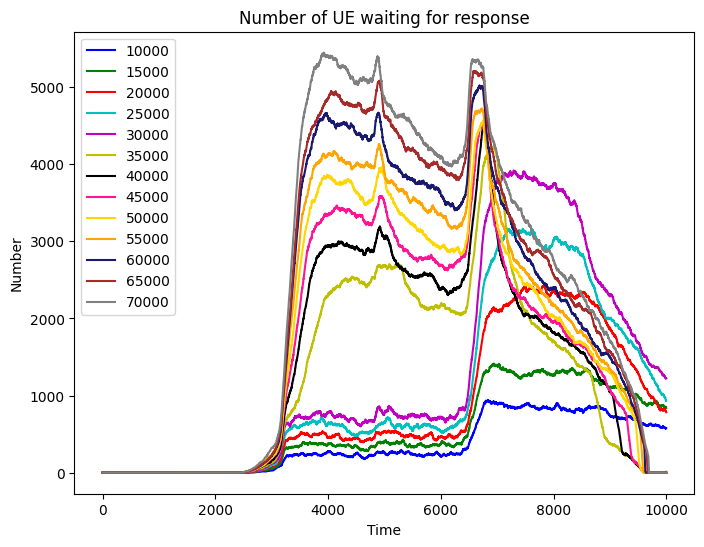

In [87]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.plot(x, data[i].numberUEWaitingResponse, label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Number of UE waiting for response')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot

plt.savefig('number_UE_waiting_for_response.png', dpi = dpi)

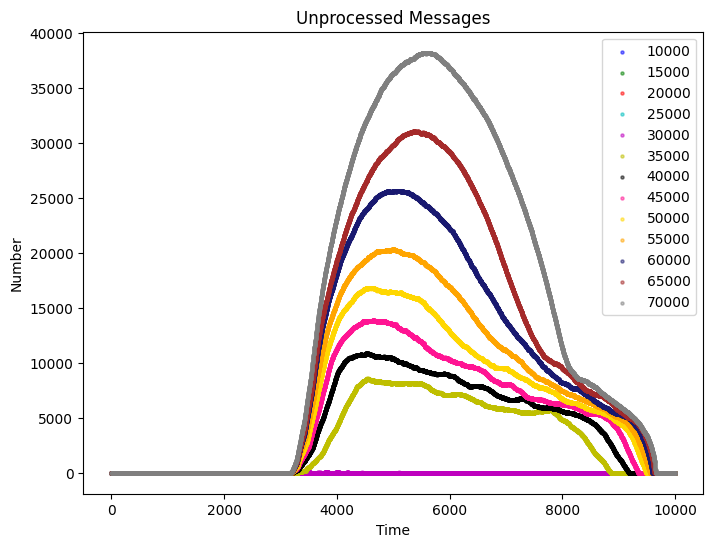

In [88]:
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.scatter(x, data[i].numberUnProcessedMessages[sat_id], label=label[i], c = color[i], s = 5, alpha = 0.5)


# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Unprocessed Messages')
plt.legend()  # Add a legend to distinguish the lines

plt.savefig('number_unprocessed_tasks.png', dpi = dpi)




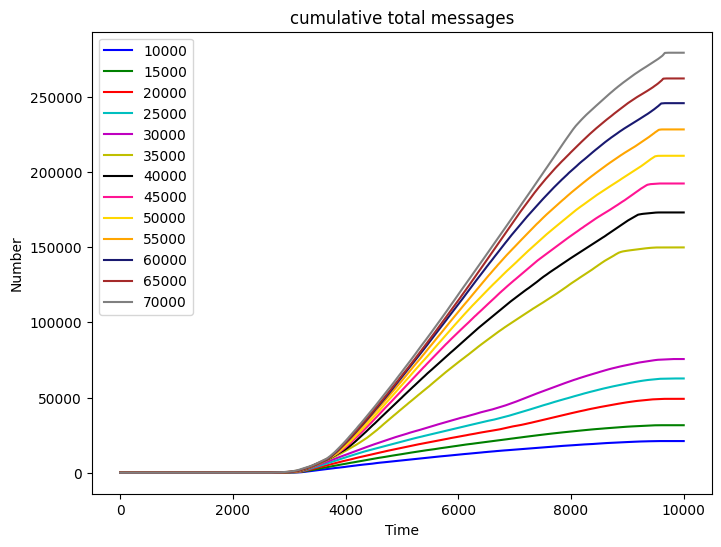

In [6]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_total_messages[sat_id], label=label[i], c = color[i])


# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative total messages in Satellite 1')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

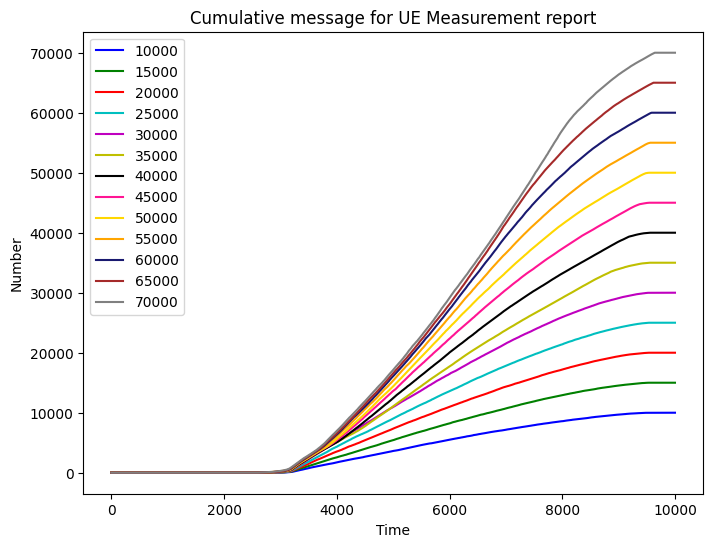

In [7]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_UE_measurement[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative message in Satellite 1 for UE Measurement report')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

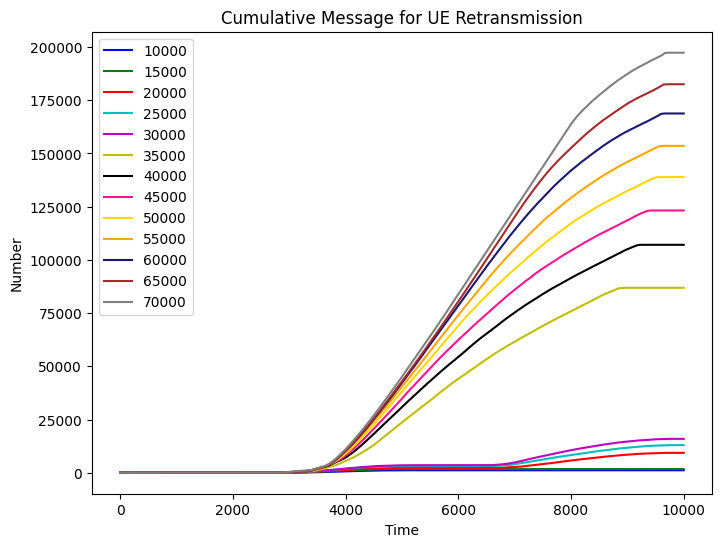

In [8]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_UE_retransmit[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative Message in Satellite 1 for UE Retransmission')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

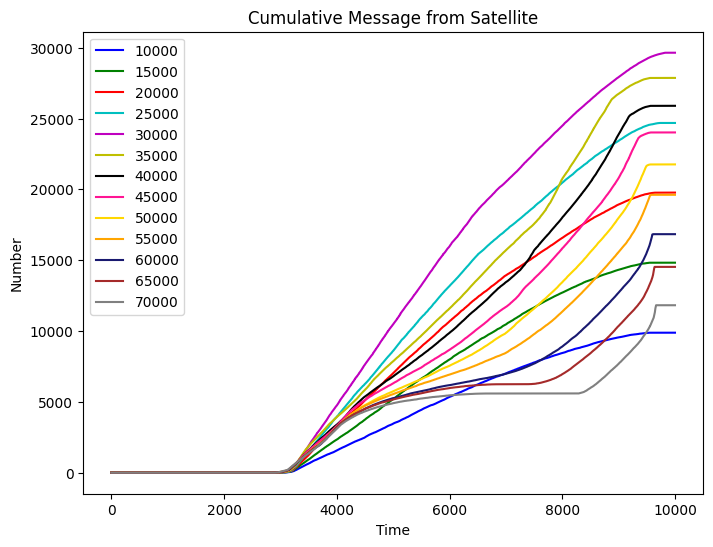

In [9]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_satellite[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative Message in Satellite 1 from Satellite')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

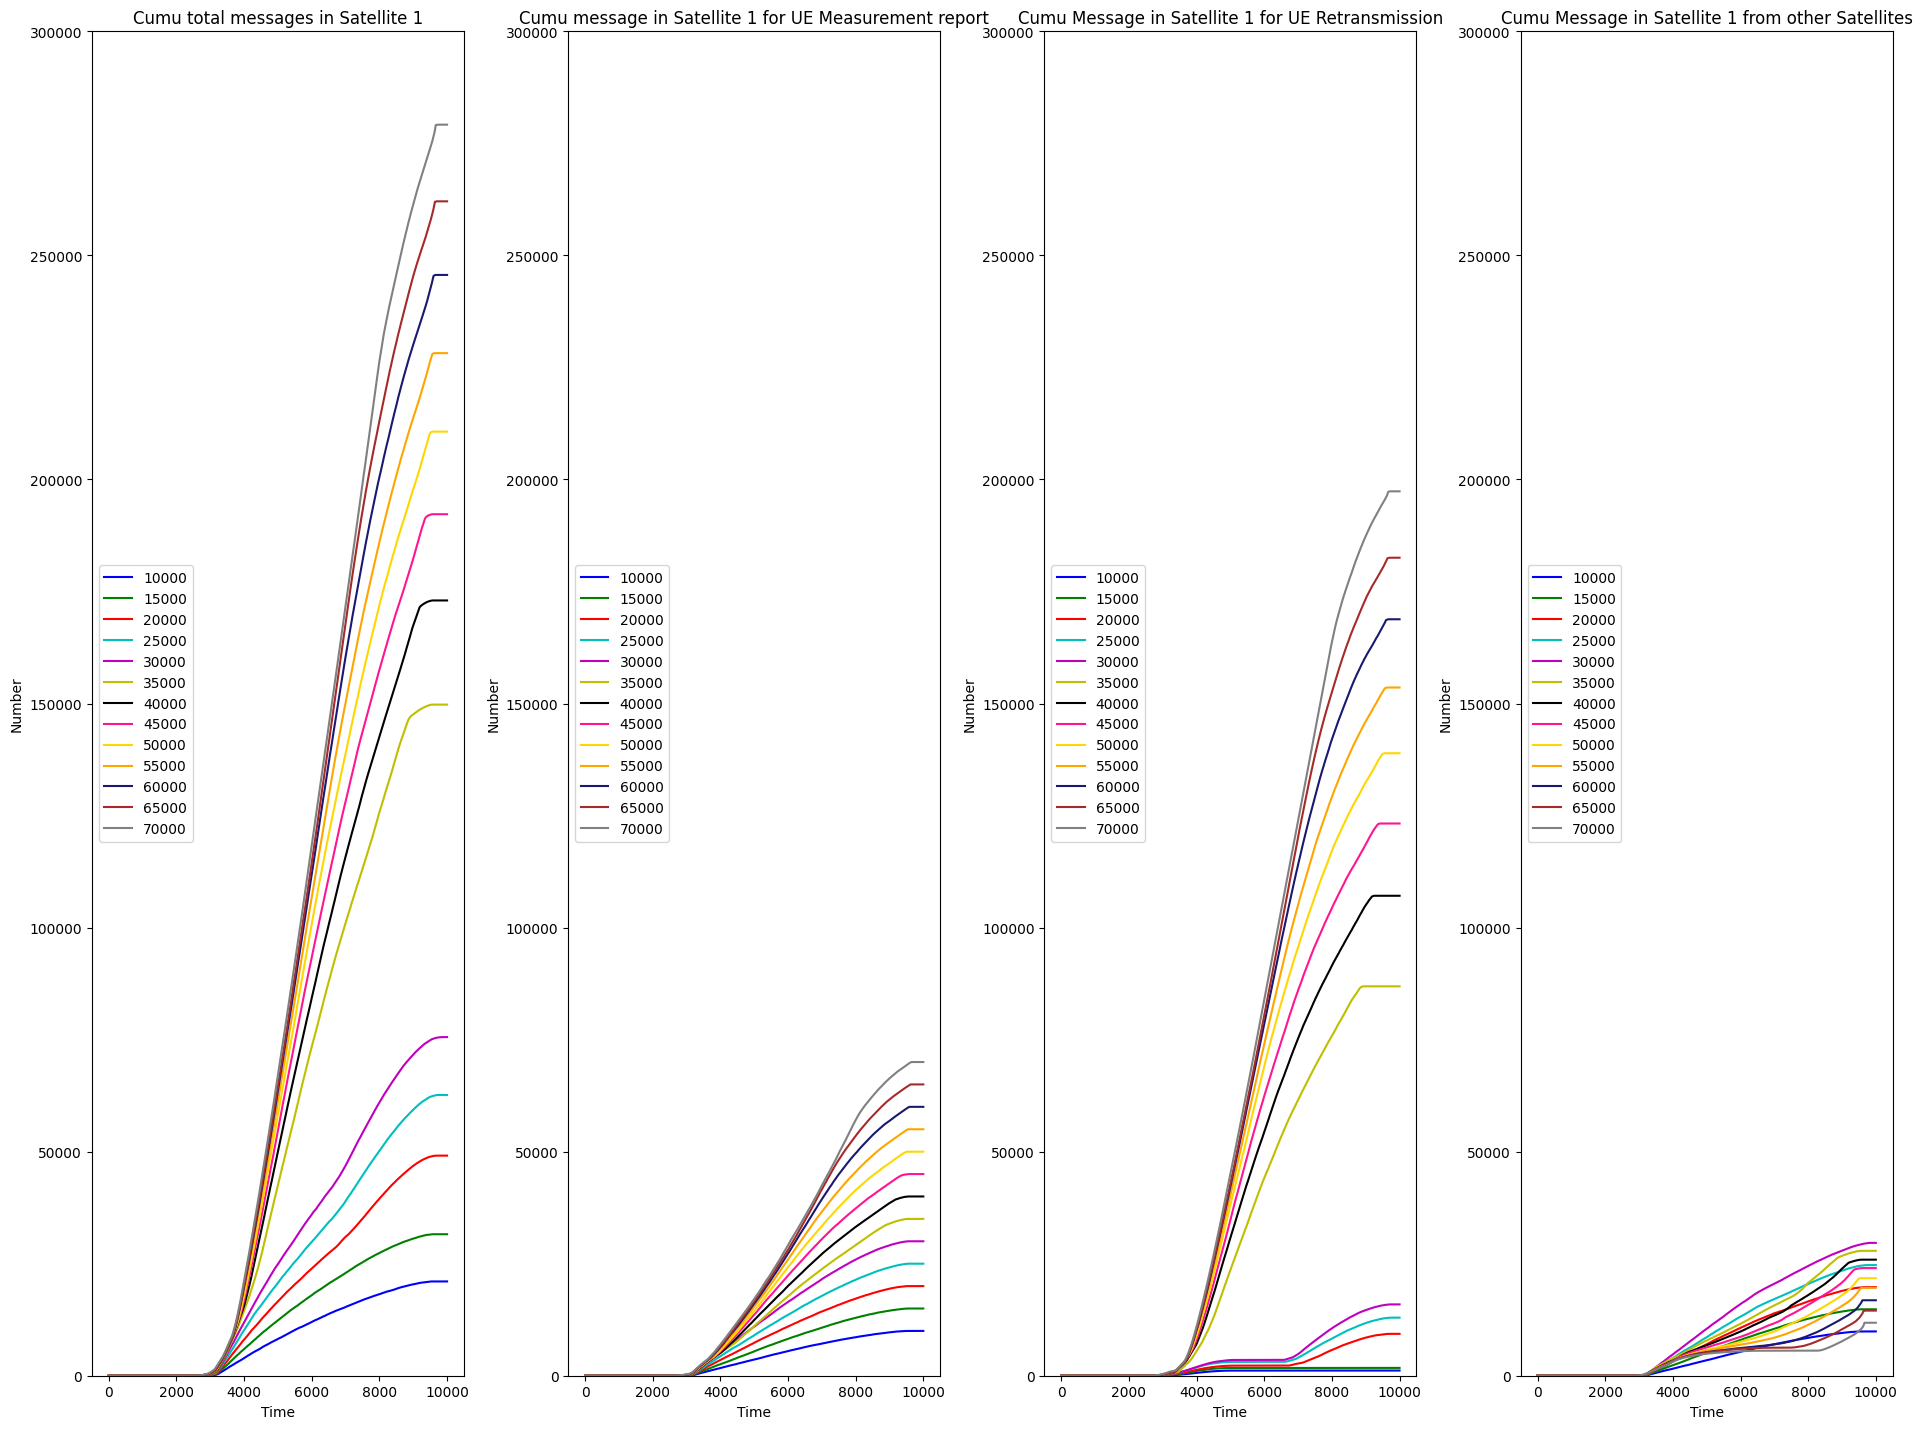

In [79]:
fig, axes = plt.subplots(1, 4, figsize=(24*0.8, 18*0.8))
sat_id = 1

axes[0].set_ylim(0, 300000)
for i in range(len(data)):
    axes[0].plot(x, data[i].cumulative_total_messages[sat_id], label=label[i], c = color[i])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Number')
axes[0].set_title('Cumu total messages in Satellite 1')
axes[0].legend(loc='center left')  # Add a legend to distinguish the lines

axes[1].set_ylim(0, 300000)
for i in range(len(data)):
    axes[1].plot(x, data[i].cumulative_message_from_UE_measurement[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number')
axes[1].set_title('Cumu message in Satellite 1 for UE Measurement report')
axes[1].legend(loc='center left')  # Add a legend to distinguish the lines

axes[2].set_ylim(0, 300000)
for i in range(len(data)):
    axes[2].plot(x, data[i].cumulative_message_from_UE_retransmit[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Number')
axes[2].set_title('Cumu Message in Satellite 1 for UE Retransmission')
axes[2].legend(loc='center left')

axes[3].set_ylim(0, 300000)
for i in range(len(data)):
    axes[3].plot(x, data[i].cumulative_message_from_satellite[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[3].set_xlabel('Time')
axes[3].set_ylabel('Number')
axes[3].set_title('Cumu Message in Satellite 1 from other Satellites')
axes[3].legend(loc='center left')
plt.tight_layout()

dpi = 300
plt.savefig('cumulative_togther.png', dpi = dpi)

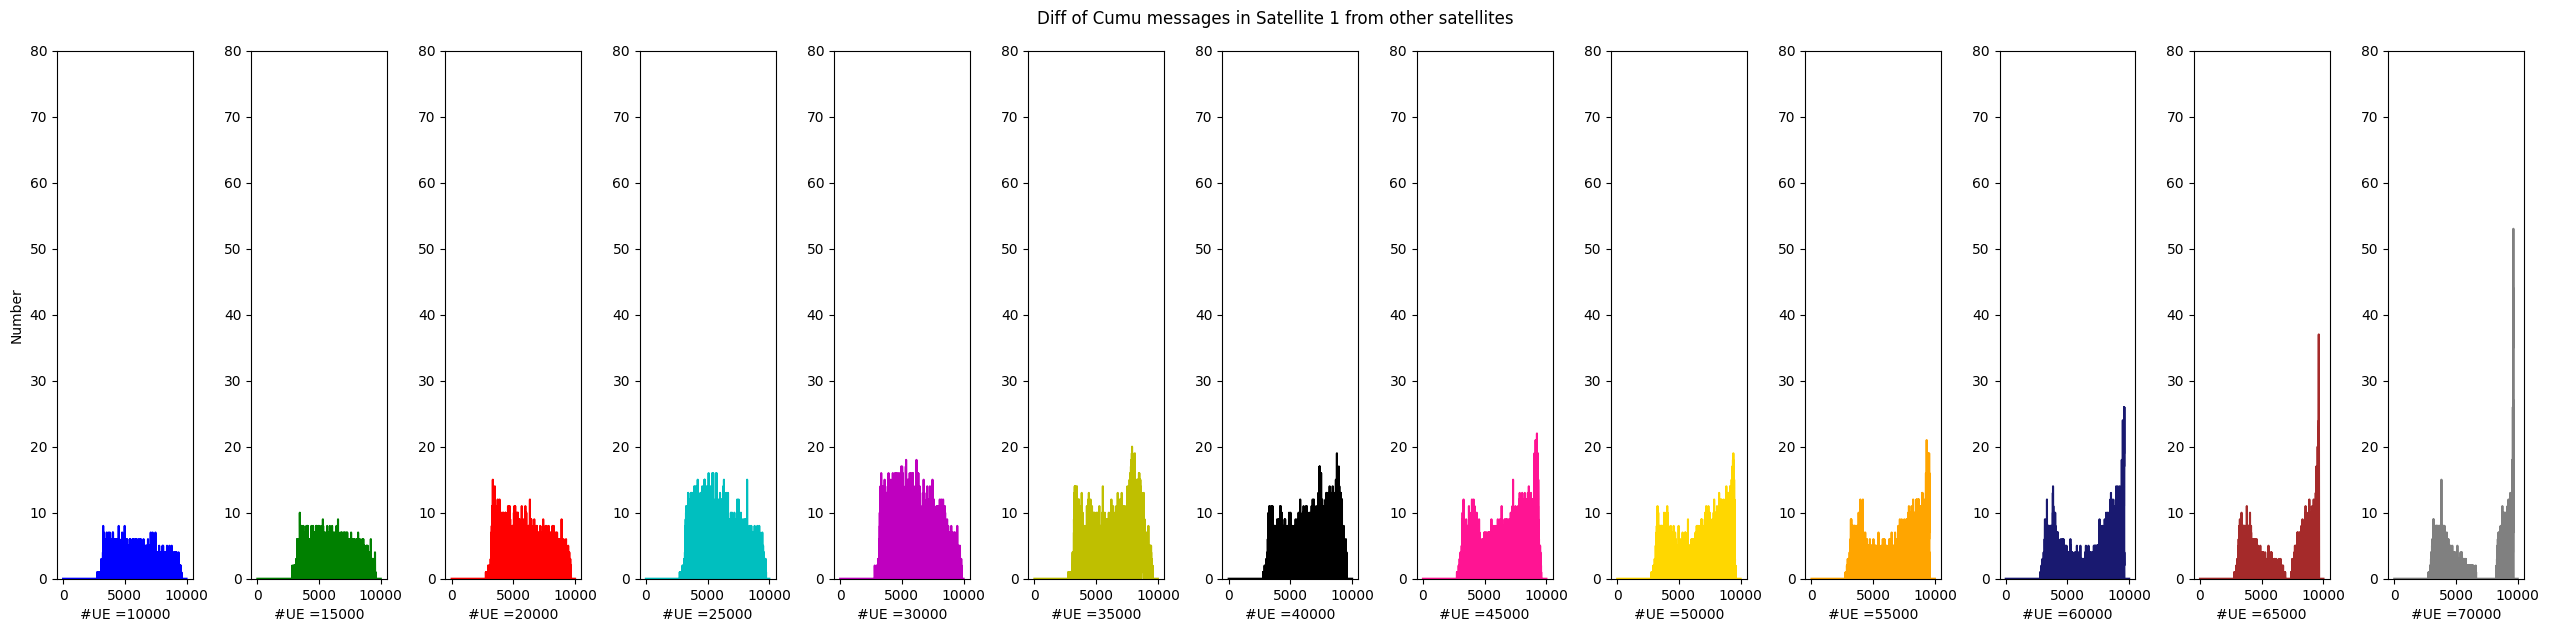

In [85]:
fig, axes = plt.subplots(1, len(data), figsize=(32*0.8, 8*0.8))
sat_id = 1

for i in range(len(data)):
    axes[i].set_ylim(0, 80)
    axes[i].plot(x[1:], np.diff(data[i].cumulative_message_from_satellite[sat_id]), label=label[i], c = color[i])
    axes[i].set_xlabel('#UE =' + str(label[i]))
    axes[0].set_ylabel('Number')
   # axes[0].legend(loc='center left')  # Add a legend to distinguish the lines
fig.suptitle('Diff of Cumu messages in Satellite 1 from other satellites')
# Centered title above subplots
#cumulative_total_messages
#cumulative_message_from_UE_measurement
#cumulative_message_from_UE_retransmit
#cumulative_message_from_satellite

plt.tight_layout()

dpi = 300
plt.savefig('diff_from_other_sat.png', dpi = dpi)